# **Projet MACS207b**  - Filtrage
- Rendu le 10 juin 2022

**Louis PERSONAZ**

**Timothée LY**

**Hypothèses :**
- $\tau \sim \mathcal{E}(\mu)$ avec $\mu = 0,2$
- $a = 5$ et $b = 10$

On calcule la fonction $h$ donnée par :
$$h(s) = \dfrac{f(s)}{1-F(s)}$$ 
où $f$ est la densité de la loi $\tau$.


Pour une loi exponentielle : 

$\forall s \in \mathbb{R}, \ f(s) = \mu e^{-\mu s} \mathbb{1}_{\mathbb{R}^+}(s)$

$\forall s \in \mathbb{R}, \ F(s) = (1 - e^{-\mu s}) \mathbb{1}_{\mathbb{R}^+}(s)$

Computing $h$ on $\mathbb{R}^+$, we obtain : 

$$
\begin{align*}
h(s) &= \dfrac{ \mu e^{-\mu s}}{1-(1 - e^{-\mu s})}\\
&= \dfrac{ \mu e^{-\mu s}}{e^{-\mu s}} \\
h(s)&= \mu
\end{align*}
$$

<u> Application numérique </u> :  h(s) = 0.2

### Imports

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set


<function seaborn.rcmod.set(*args, **kwargs)>

In [133]:
mu = 0.2
h = lambda x : mu

In [134]:
a = 5
b = 10

In [135]:
def poisson_proc(u, beg, T, seed):
    rng = np.random.default_rng(seed)
    k = rng.poisson(u*T)
    arrivals = rng.uniform(beg,T,k)
    
    return np.sort(arrivals)   

In [162]:
tau_dist = lambda rng : rng.exponential(mu)

Z = lambda t, tau : 1 if(tau <= t) else 0

N = lambda a, b, t, tau : (a + (b-a)*Z(t,tau))*t

In [163]:
def trajectory(n, a, b, seed, beg = 0, end = 10):
    rng = np.random.default_rng(seed)
    tau = tau_dist(rng)
    arrivals = np.concatenate((poisson_proc(a, beg, tau, seed),poisson_proc(a, tau, end, seed)))
    m = arrivals.size
    traj = np.zeros(n)
    t = np.linspace(beg,end,n)
    idx = 0
    for i in range(n):
        buff = 0
        if  idx < m and  t[i]>= arrivals[idx]:
            buff = 1
            idx +=1
        traj[i] = traj[i-1] + buff
    
    plt.figure(figsize = (10,5))
    plt.step(t,traj)
    plt.title("Trajectory for " + r'$\tau =$' + format(tau, ".2f") )
    plt.ylabel("N(t)")
    plt.xlabel("t")
    plt.show()
    
    return arrivals, tau

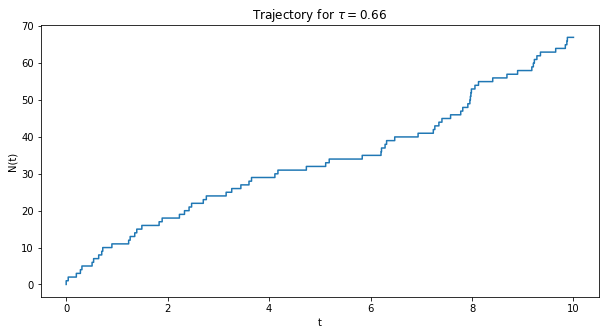

In [164]:
n = 1000
arrivals, tau = trajectory(n, a, b, 9)

In [168]:
Z = lambda t, arr : 1 if(arr <= t) else 0

def Z_hat(s,tau):
    # Formula using tau, doesn't work since we don't know tau Z(s,tau) - h(0) * min(tau,s)
    # TODO : complete

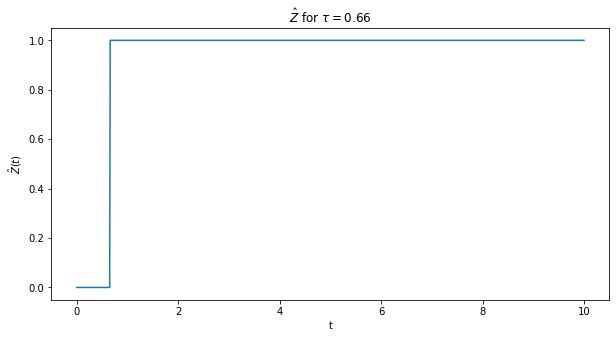

In [169]:
t = np.linspace(0,10,n)
Z_hats = np.zeros(n)

for i in range(n):
    Z_hats[i] = Z_hat(t[i],tau)
       
plt.figure(figsize = (10,5))
plt.plot(t,Z_hats)
plt.title(r'$\hat{Z}$ for $\tau =$' + format(tau, ".2f") )
plt.ylabel(r'$\hat{Z}(t)$')
plt.xlabel("t")
plt.show()
    